In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils

pd.options.mode.chained_assignment = None
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [92]:
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))

## training dataset

In [2]:
def pre_train(df):
    df["number"] = df["revenue"] / df["price"]
    
    ################################################# given label
    click = df[(df.click == 1)]
    basket = df[(df.basket == 1)]
    order = df[(df.order == 1)]
    click["class_label"] = 0
    basket["class_label"] = 0
    order["class_label"] = 1
    df1 = pd.concat([click, basket, order])
    return df1

In [55]:
df_train0 = pd.read_csv("train.csv", sep = "|")
print(df_train0.shape)

### Transfer to classification and regression question
df_train = pre_train(df_train0)
df_train = df_train.sort_values(['lineID'], ascending = True)
print(df_train.shape)
df_train.head()

(2756003, 11)
(2756003, 13)


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,number,class_label
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00,0.0,0
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00,0.0,0
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00,0.0,0
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55,1.0,1
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14,1.0,1


### 計算商品出現頻率，找出重要與不重要的商品

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


         pid  lineID
2642    2655   53785
2478    2491   14666
16563  16641   12369
16068  16144   11134
7365    7403   10002


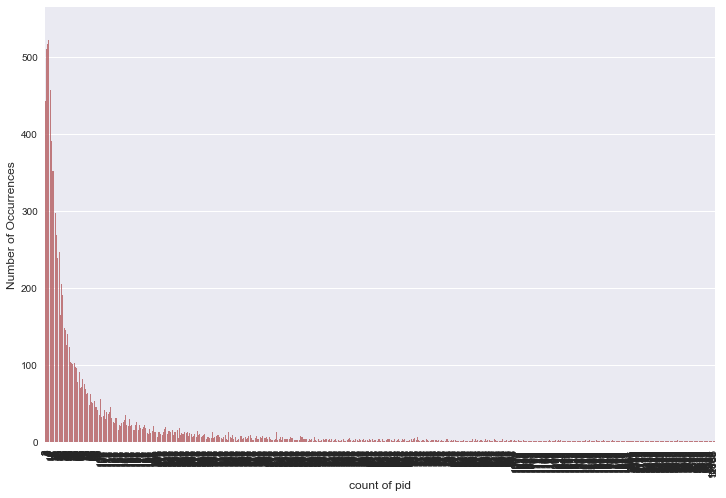

In [42]:
import seaborn as sns
color = sns.color_palette()

cnt_srs0 = df_train.groupby(["pid"])["lineID"].aggregate("count").reset_index()
cnt_srs = cnt_srs0.sort(columns = "lineID", axis = 0, ascending = False)
print(cnt_srs.head())
cnt_srs = cnt_srs.lineID.value_counts()
#print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('count of pid', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [56]:
cnt_srs0.columns = ["pid", "fre"]
df_train = df_train.merge(cnt_srs0, how='inner', on="pid", left_on=None, right_on=None,
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_x', '_y'), copy=True, indicator=False)

df_train = df_train.sort(columns = "lineID", axis = 0, ascending = True)
df_train = df_train.reset_index(drop = True, inplace = False, col_level = 0, col_fill = '')
df_train.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,number,class_label,fre
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00,0.0,0,64
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00,0.0,0,2333
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00,0.0,0,27
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55,1.0,1,6833
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14,1.0,1,444


In [72]:
threshold_frequence = 32
print("Number of pid under threshold :", cnt_srs0[(cnt_srs0.fre < threshold_frequence)].shape[0])
print("Percent of dataset whose pid under threshold :", (df_train[(df_train.fre < threshold_frequence)].shape[0]) / (df_train.shape[0]))

Number of pid under threshold : 10822
Percent of dataset whose pid under threshold : 0.05171946474659135


In [136]:
df_train = df_train[df_train.fre >= threshold_frequence]

# Item Clustering

In [117]:
df_items00 = pd.read_csv("items.csv", sep = "|")
print(df_items00.shape)

del df_items00["campaignIndex"]
df_items00.pharmForm = df_items00.pharmForm.str.upper()
display(df_items00.isnull().sum())

(22035, 11)


pid                  0
manufacturer         0
group                0
content              0
unit                 0
pharmForm         2327
genericProduct       0
salesIndex           0
category          4627
rrp                  0
dtype: int64

In [118]:
### 前處理content的資料型態
content = pd.DataFrame(df_items00.content.str.split('X',2).tolist(), columns = ['x','y','z'])
content = content.fillna('1')
content.x = pd.to_numeric(content.x, errors='coerce')
content.y = pd.to_numeric(content.y, errors='coerce')
content.z = pd.to_numeric(content.z, errors='coerce')
content['Content'] = content.x * content.y * content.z
df_items00 = pd.concat([df_items00, content], axis=1, join_axes=[df_items00.index])
del df_items00["x"]
del df_items00["y"]
del df_items00["z"]
del df_items00["content"]

### 將categorical columns轉成數字型態
df_items00.group = df_items00.group.astype("category").cat.codes
df_items00.unit = df_items00.unit.astype("category").cat.codes
df_items00.pharmForm = df_items00.pharmForm.astype("category").cat.codes
#df_items = pd.get_dummies(df_items)

df_items00.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,NaN,10.89,80.0
1,2,1,529,7,135,0,40,NaN,10.89,80.0
2,3,1,529,1,45,0,40,NaN,16.45,10.0
3,4,1,529,7,135,0,40,NaN,10.89,80.0
4,5,2,74,7,112,0,40,1.0,22.53,8.0


In [119]:
### Filling Missing Value
df_items00.category = df_items00.category.fillna(value = np.mean(df_items00.category))
df_items00.Content = df_items00.Content.fillna(value = np.mean(df_items00.Content))
df_items00.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,113.933996,10.89,80.0
1,2,1,529,7,135,0,40,113.933996,10.89,80.0
2,3,1,529,1,45,0,40,113.933996,16.45,10.0
3,4,1,529,7,135,0,40,113.933996,10.89,80.0
4,5,2,74,7,112,0,40,1.000000,22.53,8.0


### 刪掉交易次數很少的

In [120]:
df_items0 = df_items00.merge(cnt_srs0, how='inner', on="pid", left_on=None, right_on=None,
                              left_index=False, right_index=False, sort=True,
                              suffixes=('_x', '_y'), copy=True, indicator=False)
df_items0 = df_items0.reset_index(drop = True, inplace = False, col_level = 0, col_fill = '')
df_items0.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,fre
0,1,1,529,7,135,0,40,113.933996,10.89,80.0,8
1,2,1,529,7,135,0,40,113.933996,10.89,80.0,3
2,3,1,529,1,45,0,40,113.933996,16.45,10.0,14
3,4,1,529,7,135,0,40,113.933996,10.89,80.0,13
4,5,2,74,7,112,0,40,1.000000,22.53,8.0,29


In [121]:
df_items1 = df_items0[(df_items0.fre >= threshold_frequence)]
del df_items1["fre"]
df_items1 = df_items1.reset_index(drop = True, inplace = False, col_level = 0, col_fill = '')
df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,7,3,488,7,145,0,53,3.0,21.45,15.0
1,8,1,529,7,135,0,40,2.0,10.89,80.0
2,10,4,184,7,43,0,40,4.0,21.99,30.0
3,11,4,184,7,43,0,40,4.0,38.49,60.0
4,12,5,132,7,73,1,40,5.0,9.85,14.0


### Dummies varible and MinMax(0, 1)

In [122]:
def onehot2(df):
    df_le = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_le.shape[1]
    print('original dimension : %d' % df_le.shape[1])
    return df_le, original_dim

In [123]:
g1, g1_dim = onehot2(df_items1.group)
p1, p1_dim = onehot2(df_items1.pharmForm)
u1, u1_dim = onehot2(df_items1.unit)
m1, m1_dim = onehot2(df_items1.manufacturer)
s1, s1_dim = onehot2(df_items1.salesIndex)

df_items_oh0 = pd.concat([df_items1, g1, p1, u1, m1, s1], axis=1, join_axes=[df_items1.index])
df_items_oh = df_items_oh0.drop(["group", "pharmForm", "unit", "manufacturer", "salesIndex"], axis=1)
df_items_oh.columns = [np.arange(1, (pd.DataFrame(df_items_oh).shape[1]+1), 1)]
df_items_oh.rename(columns={1: 'pid', 3: 'category', 4: 'rrp', 5: 'Content'}, inplace = True)
df_items_oh.head()

original dimension : 533
original dimension : 183
original dimension : 8
original dimension : 1067
original dimension : 54


,pid,2,category,rrp,Content,6,7,8,9,10,...,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850
0,7,0,3.0,21.45,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8,0,2.0,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,0,4.0,21.99,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,0,4.0,38.49,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,1,5.0,9.85,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
column_conti = ["category","rrp","Content"]
df_num = df_items_oh[column_conti]

sc = MinMaxScaler(feature_range = (0, 1), copy = True)
Z = pd.DataFrame(sc.fit_transform(df_num))
Z.columns = column_conti

df_cat = df_items_oh.drop(column_conti, axis = 1)
df_cat = df_cat.reset_index(drop = True, inplace = False, col_level = 0, col_fill = '')

df_st = df_cat.join(Z, on = None, how = 'inner', lsuffix = '', rsuffix = '', sort = False)
df_st.head()

,pid,2,6,7,8,9,10,11,12,13,...,1844,1845,1846,1847,1848,1849,1850,category,rrp,Content
0,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004902,0.080376,0.000670
1,8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002451,0.040677,0.003625
2,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007353,0.082406,0.001352
3,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007353,0.144436,0.002716
4,12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009804,0.036767,0.000625


In [127]:
missing(Z)
missing(df_cat)
missing(df_items_oh)

Size of testing dataset : 11106
Size of testing dataset DropNA : 11106
Size of testing dataset : 11106
Size of testing dataset DropNA : 11106
Size of testing dataset : 11106
Size of testing dataset DropNA : 11106


## Kmeans and PCA

In [128]:
X = df_st.iloc[:, 1:]

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2,
          copy = True,
          whiten = False,
          svd_solver = 'auto',
          tol = 0.0,
          iterated_power = 'auto',
          random_state = 100)

In [130]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2,
            perplexity = 30.0,
            early_exaggeration = 4.0,
            learning_rate = 1000.0,
            n_iter = 1000,
            n_iter_without_progress = 30,
            min_grad_norm = 1e-07,
            metric = 'euclidean',
            init = 'random',
            verbose = 0,
            random_state = 100,
            method = 'barnes_hut',
            angle = 0.5)

In [131]:
def kmeans(n_clusters):
    ### kmeans
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = n_clusters,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    precompute_distances = 'auto',
                    verbose = 0,
                    random_state = 100,
                    copy_x = True,
                    n_jobs = 1,
                    algorithm = 'auto')
    kmeans.fit(X)
    label = pd.DataFrame(kmeans.labels_)
    
    ### pca->2
    X_pca = pd.DataFrame(pca.fit_transform(X))
    X1 = pd.concat([X_pca, label], axis=1, join_axes=[X_pca.index])
    X1.columns = ["pc1","pc2","label"]
    print(X1["label"].value_counts())
    
    ### plot
    cmap = cm.get_cmap('Spectral')
    X1.plot.scatter(x = "pc1", y = "pc2", s = 10, c = "label", cmap = cmap)
    plt.show()
    return label

2    4065
1    3816
0    3225
Name: label, dtype: int64


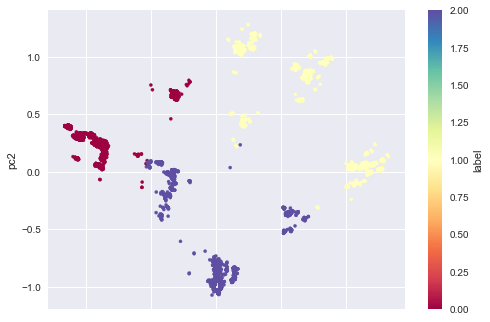

In [132]:
label = kmeans(3)

In [133]:
df_items1["cluster"] = label
df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,cluster
0,7,3,488,7,145,0,53,3.0,21.45,15.0,2
1,8,1,529,7,135,0,40,2.0,10.89,80.0,1
2,10,4,184,7,43,0,40,4.0,21.99,30.0,1
3,11,4,184,7,43,0,40,4.0,38.49,60.0,1
4,12,5,132,7,73,1,40,5.0,9.85,14.0,1


## combine training and items

In [137]:
result0 = pd.merge(df_train, df_items1, how='inner', on=['pid']) #df_items
result0 = result0.sort_values(['lineID'], ascending=True)

##################################################### hold on last month
hold_result = result0[result0.day > 65]
hold_result = hold_result.dropna()
hold_result = hold_result.reset_index(drop = True)

result = result0[result0.day < 66]
result = result.dropna()
result = result.reset_index(drop = True)

print('Number of hold_result: %d' % hold_result.shape[0])
print('Number of result training: %d' % result.shape[0])
result.head()

Number of hold_result: 821329
Number of result training: 1707466


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,cluster
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,529,5,147,0,40,193.0,18.25,50.0,1
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,18,373,7,135,1,40,66.0,18.81,50.0,1
2,4,1,1145,1,1,6.59,0,0,1,6.55,...,52,308,1,44,0,40,25.0,9.31,60.0,1
3,5,1,3394,0,1,4.39,0,0,1,4.14,...,90,458,7,75,0,53,14.0,8.13,50.0,2
4,6,1,3661,0,1,13.66,0,0,1,10.03,...,90,249,5,83,0,52,127.0,21.60,1000.0,0


In [152]:
result_clu = result[(result.cluster == 1)]

X = result_clu.drop(["number", "class_label", "click", "basket", "order", "fre", "revenue", "cluster"], axis=1)
y = result_clu[["number", "class_label"]]

print(result_clu.shape[0], X.shape[0], y.shape[0])

921622 921622 921622


In [145]:
def pre_all(df):
    # 連續
    df_num = df[column_conti]
    sc = StandardScaler(copy=True, with_mean = True, with_std = True)
    Z = pd.DataFrame(sc.fit_transform(df_num))
    Z.columns = column_conti
    # 類別
    df_cat = df.drop(column_conti, axis=1)
    df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')
    
    df_st = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)
    df_st1 = pd.get_dummies(df_st)
    return df_st1

In [147]:
print(y['class_label'].value_counts())

column_conti = ["lineID", "day", "pid", "competitorPrice", "price", "manufacturer", "unit",
                "group", "pharmForm", "salesIndex", "category", "rrp", 'Content']
df_st = pre_all(X)

0    648701
1    272921
Name: class_label, dtype: int64


In [148]:
def split(X, y):
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    return X_train, X_test, y_train, y_test

def cross_val(model, cv):
    from sklearn.cross_validation import cross_val_score
    scores_dt0 = cross_val_score(model, X_train, y_train, cv = cv, n_jobs = 4)  
    scores_dt = np.sum(scores_dt0) / cv
    
    print("===cross_val===")  
    print(scores_dt)  

In [149]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, 
                            max_features = 'log2', 
                            criterion = 'mse', 
                            max_depth = None, 
                            min_samples_split = 20, 
                            min_samples_leaf = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes = None, 
                            min_impurity_split = 1e-07, 
                            bootstrap = True, 
                            oob_score = True, 
                            n_jobs = 1, 
                            random_state = 0, 
                            verbose = 0, 
                            warm_start = False)

In [153]:
X_train, X_test, y_train, y_test = split(df_st, y["number"])

Number of training: 737297
Number of testing: 184325


In [151]:
#cross_val(rfr, 10)

In [ ]:
rfr.fit(X_train, y_train)  
pred = rfr.predict(X_test).reshape(y_test.shape[0], 1)  
print(rfr.oob_score_)  

### Score
score = np.dot((pred - y_test).T, (pred - y_test))  
print("===Euclidean Distance===")  
print(score[0, 0])  

### scatter plot
a = pd.DataFrame(np.concatenate((np.array(y_test), pred), axis=1))  
a.columns = ["test", "pred"]  
a.plot.scatter(x = 'test', y = 'pred', s = 10, alpha = 0.2)  
plt.show()  

0.116242491645


0.112749478825, 9904614.19936

In [126]:
label_number = np.array(df0['order'].value_counts())
weight = float(label_number[0] / label_number[1])

In [127]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0
                              ,class_weight = {1: weight, 0: 1.0})

In [153]:
X_train, X_test, y_train, y_test = split(df_st, y["class_label"])

Number of training: 737297
Number of testing: 184325


In [128]:
def processing(model):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix

    model.fit(X_train, y_train)
    print("training down")
    y_pred = model.predict(X_test).reshape(y_test.shape[0], 1)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy : %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))
    print('Accuracy (sklearn): %.2f' % accuracy_score(y_test, y_pred))
    print("==confusion matrix==")
    print(confusion_matrix(y_test, y_pred, labels=[0,1], sample_weight=None))

In [129]:
processing(tree)

training down
Misclassified samples: 61606
Accuracy : 0.00
Accuracy (sklearn): 0.67
==confusion matrix==
[[100131  30457]
 [ 31149  23177]]


> 0.69 2,  
0.67 1,  
0.63 0